# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: xxxx
- Nombre y Apellidos
- Nombre y Apellidos
- ...
- Nombre y Apellidos

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


---
Importamos todos los paquetes aquí por comodidad

In [15]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from mltools import model_tools as MT
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from mltools import classification_tools as CT
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

### 1. AJUSTE DE LOS MODELOS CON EL DATASET AJU_DATOS_DEM_C3

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni ANNO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

Carga de datos

In [16]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('AJU_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format='%d/%m/%Y') 
s=df_aju.loc[:,'FECHA']
df_aju['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,0,16.1,23.0
2875,2021-12-28,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,0,16.6,22.7
2876,2021-12-29,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,0,14.3,21.3
2877,2021-12-30,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,0,13.4,26.4


Visión general de las series

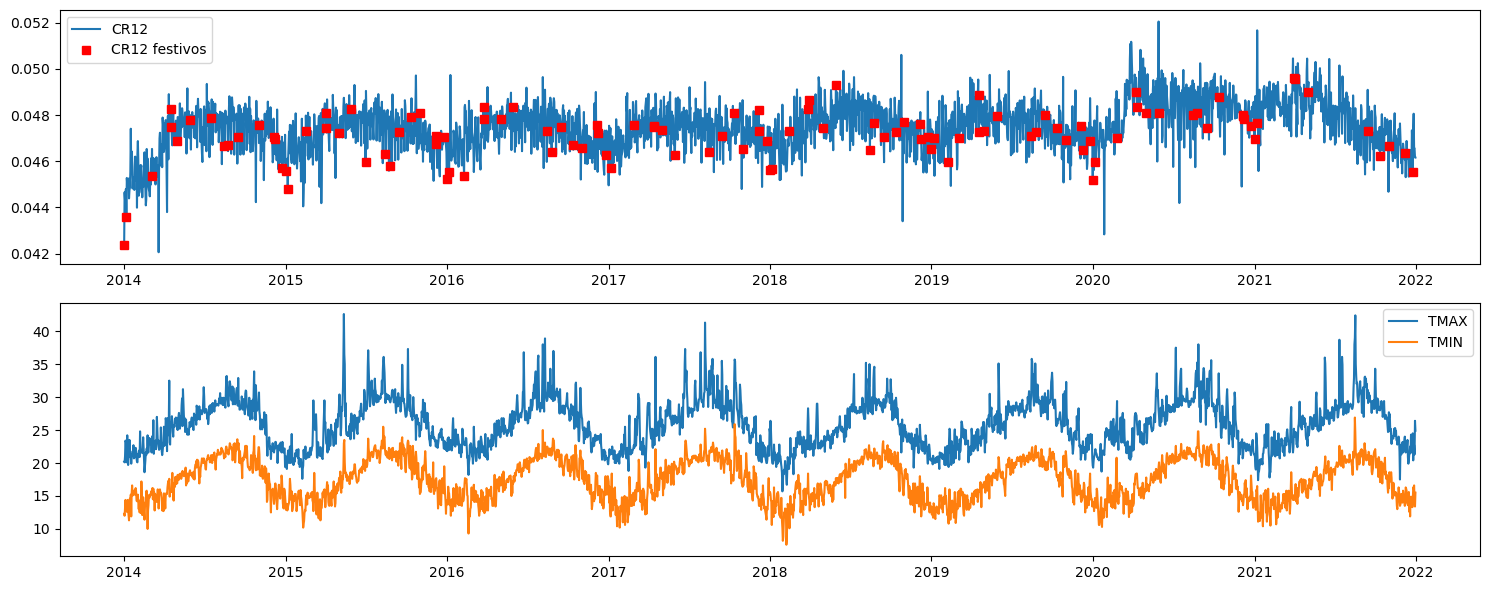

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [17]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))
ax1 = plt.subplot(2,1,1)

ind_festivo = df_aju.FESTIVO == 1

plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')

plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX')
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

In [18]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
#Primero convertimos la variable de salida en category
df_aju['FESTIVO'] = df_aju['FESTIVO'].astype('category')


In [ ]:
sns.pairplot(df_aju, hue="FESTIVO")

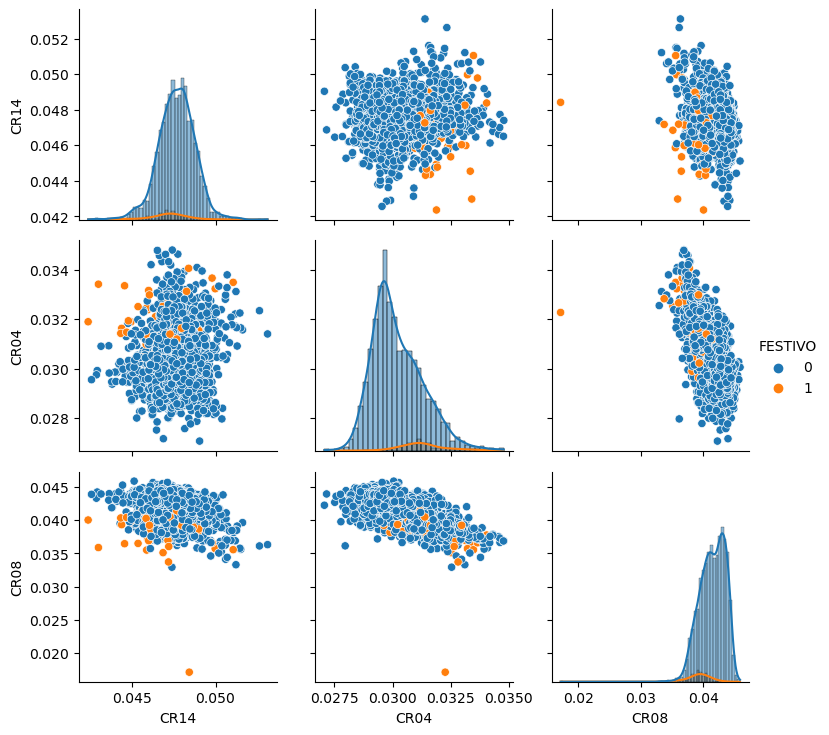

In [29]:
# Focus on interesting variables
g = sns.PairGrid(df_aju, vars=["CR14", "CR04","CR08"], hue="FESTIVO")
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

- Al tener clases tan desbalanceadas se hace un poco dificil apreciar que variable podria clasificar mejor asi a simple vista ya que la mayoria de puntos que vemos en el scatter plot son azules que son los dias que no son festivos. Además, como ya mencionaré mas abajo no hay ninguna variable que tenga una relacion alta con la variable de salida. Al tener tantas variables hemos hecho graficas solamente de aquellas tres variables que sospechamos que pueden tener mayor relacion con la variable FESTIVO.

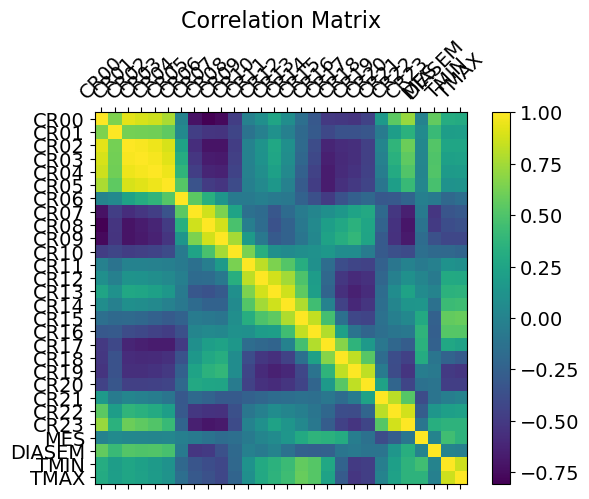

In [20]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
f = plt.figure()
plt.matshow(df_aju.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [21]:
df_aju.corr()

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,CR18,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,TMIN,TMAX
CR00,1.000000,0.649143,0.924715,0.892032,0.860473,0.767746,0.004409,-0.721845,-0.806965,-0.759511,...,-0.516594,-0.535506,-0.452476,0.166705,0.541708,0.722006,-0.005375,0.568827,0.310718,0.297573
CR01,0.649143,1.000000,0.624885,0.615096,0.605932,0.553999,0.044173,-0.470424,-0.529553,-0.536335,...,-0.349983,-0.349859,-0.324765,-0.055107,0.195872,0.347357,0.054423,0.414960,0.198179,0.205916
CR02,0.924715,0.624885,1.000000,0.979619,0.955395,0.887785,0.235442,-0.573455,-0.713695,-0.712224,...,-0.578024,-0.561563,-0.464948,0.014528,0.376458,0.594505,0.026376,0.516022,0.255317,0.252257
CR03,0.892032,0.615096,0.979619,1.000000,0.978747,0.920995,0.310423,-0.520807,-0.667190,-0.677042,...,-0.593601,-0.563694,-0.464139,-0.015224,0.337686,0.555233,0.025375,0.504434,0.222252,0.223928
CR04,0.860473,0.605932,0.955395,0.978747,1.000000,0.954225,0.374179,-0.474611,-0.616910,-0.631394,...,-0.582644,-0.543472,-0.454088,-0.039213,0.300114,0.512880,0.017059,0.508255,0.178878,0.184403
CR05,0.767746,0.553999,0.887785,0.920995,0.954225,1.000000,0.524099,-0.345934,-0.495345,-0.527366,...,-0.553492,-0.507898,-0.434821,-0.101760,0.206940,0.408313,0.021452,0.470761,0.113313,0.122762
CR06,0.004409,0.044173,0.235442,0.310423,0.374179,0.524099,1.000000,0.546517,0.334508,0.134935,...,-0.349632,-0.250586,-0.195737,-0.309131,-0.298799,-0.226559,-0.027390,-0.069316,-0.197738,-0.156116
CR07,-0.721845,-0.470424,-0.573455,-0.520807,-0.474611,-0.345934,0.546517,1.000000,0.868325,0.641257,...,0.148874,0.237888,0.282117,-0.191226,-0.513312,-0.649214,-0.068658,-0.518938,-0.330253,-0.300040
CR08,-0.806965,-0.529553,-0.713695,-0.667190,-0.616910,-0.495345,0.334508,0.868325,1.000000,0.876163,...,0.275925,0.351540,0.258847,-0.234825,-0.540730,-0.694788,-0.121456,-0.499927,-0.382115,-0.357476
CR09,-0.759511,-0.536335,-0.712224,-0.677042,-0.631394,-0.527366,0.134935,0.641257,0.876163,1.000000,...,0.315482,0.387928,0.247627,-0.296883,-0.550756,-0.674168,-0.165874,-0.355954,-0.425298,-0.419720


Aqui estamos estudiando la relacion que tienen las variables, unas con otras, ademas de con la salida. Puntos interesantes:

- Hay varias variables de entrada que están bastante correlacionada entre ellas como por ejemplo CR00 y CR02 con una correlacion de 0.979, esto quiere decir que una puede explicar a la otra y que a la hora de hacer nuestro modelo podemos llegar a no contar con una de ellas como input ya que tenemos la otra. Otros ejemplos de correlaciones altas son CR03 y CR04 o CR02 y CR00. Por otro lado, tambien hemos encontrado variables que estaban alta pero inversamente correlacionadas como CR00 y CR08 con una correlacion igual a -0.806.


#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

In [23]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Define input and output matrices
INPUTS = df_aju.columns[~df_aju.columns.isin(['FESTIVO', 'FECHA', ''])]
OUTPUT = 'FESTIVO'
X = df_aju[INPUTS]
y = df_aju[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
df_aju_tr = X_train.copy()
df_aju_tr['FESTIVO'] = y_train # We will call Y as output variable for simplicity
df_aju_ts = X_test.copy()
df_aju_ts['FESTIVO'] = y_test # We will call Y as output variable for simplicity>

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

In [35]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_DT = INPUTS

# Cuanto mas grande sea el min_impurity_decrease, mas sencillo va a ser mi árbol (es un hyperparameter)
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure - también se puede utilizar "entropy"
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='accuracy')

In [36]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

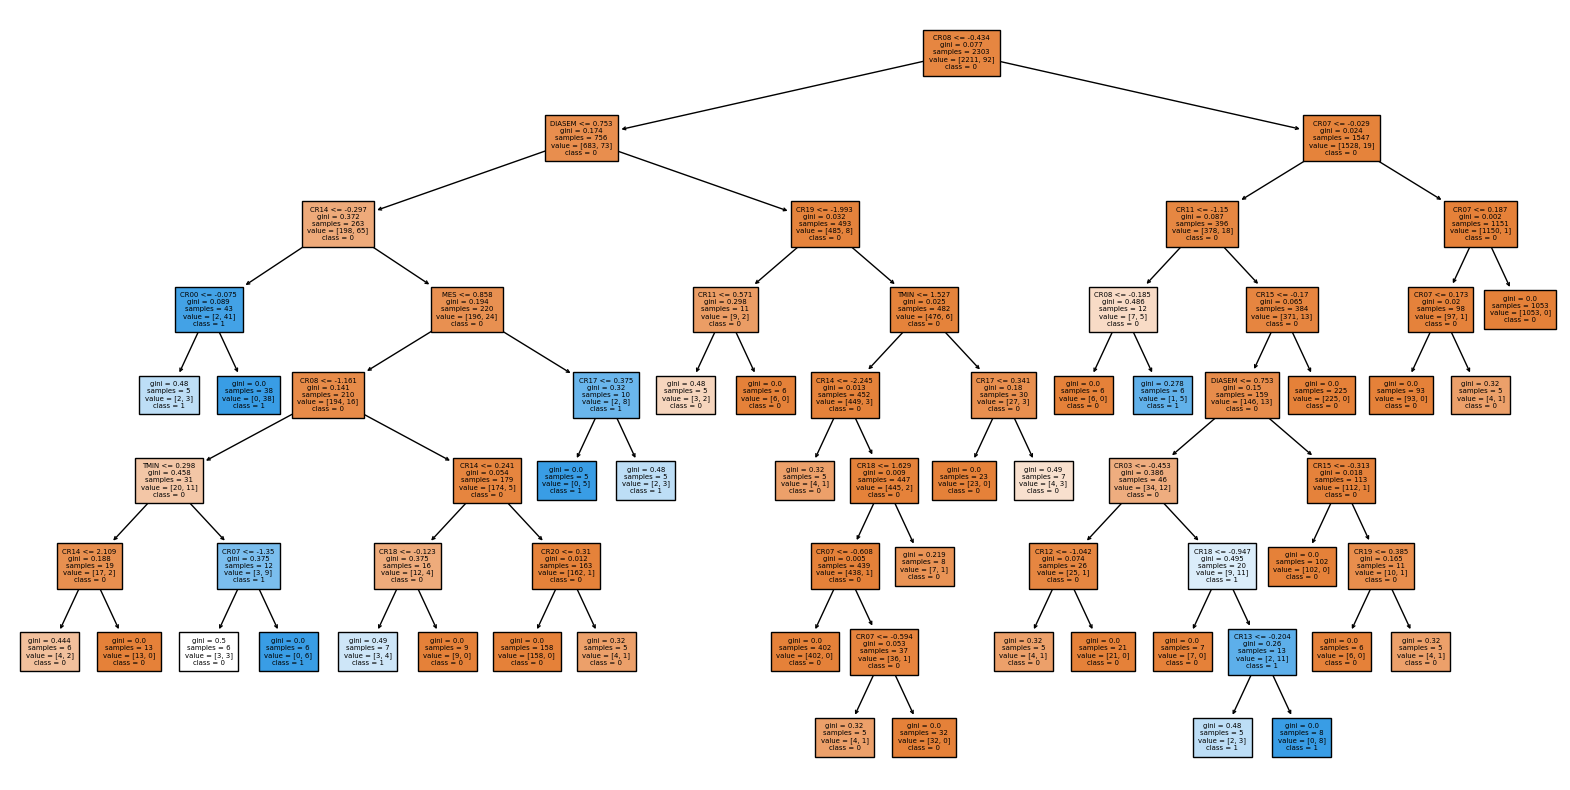

In [37]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], # Utiliza los parámetros óptimos obtenidos de la búsqueda de la cuadrícula
          feature_names= INPUTS_DT, # Lista de variables utilizadas en el modelo
          class_names= [str(s) for s in y_train.unique()], # Lista de nombres de las clases objetivo en el modelo
          fontsize=5, # Tamaño de fuente utilizado en la visualización del árbol
          filled=True) # Las cajas del árbol se colorearán según la mayoría de la clase objetivo
plt.show()

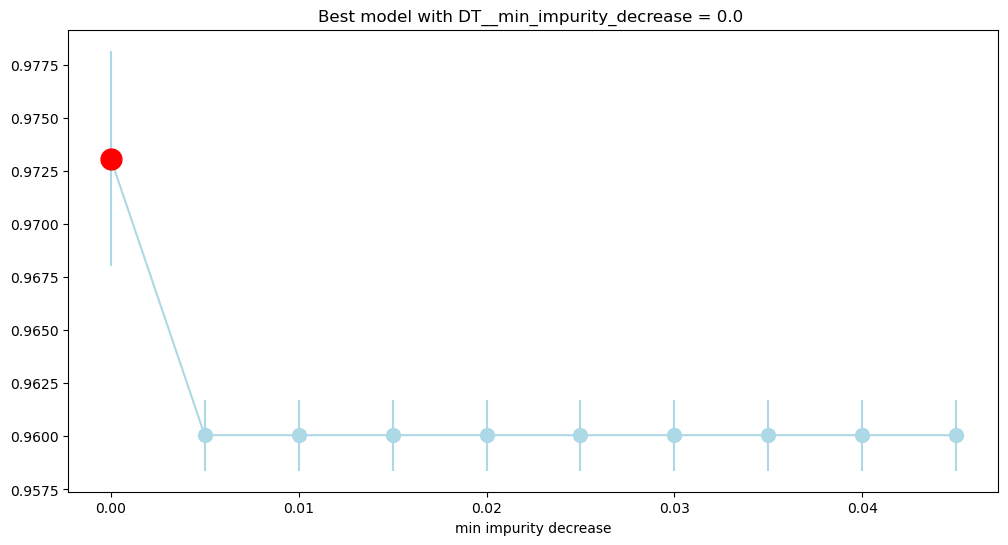

In [38]:
MT.plotModelGridError(tree_fit)

El valor mas optimo del parametro min_impurity_decrease es igual a 0, lo que significa que se permiten todas las divisiones que reducen la impureza, incluso si la reducción es muy pequeña. Al establecer un valor mínimo de min_impurity_decrease, podemos limitar el crecimiento del árbol y evitar el sobreajuste.El valor mas optimo del parametro min_impurity_decrease es igual a 0 

In [27]:
clf = tree_fit.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()

# main metrics
# Se calcula la precisión y la precisión equilibrada
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

# Se crean las confusion matrixs
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[1, 0])
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[1, 0])

                         TR        TS
Accuracy           0.960052  0.960069
Balanced accuracy  0.500000  0.500000

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference  1    0
         1  0   92
         0  0 2211

Accuracy: 0.96
No Information Rate: 0.96
P-Value [Acc > NIR]: 0.53
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference  1   0
         1  0  23
         0  0 553

Accuracy: 0.96
No Information Rate: 0.96
P-Value [Acc > NIR]: 0.56
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.0
Recall: 0.0
Prevalence: 0.96
Detection Rate: 0.96
Detection prevalence: 1.0
Balanced accuracy: 0.5
F1 Score: 0.0
Positive label: 1


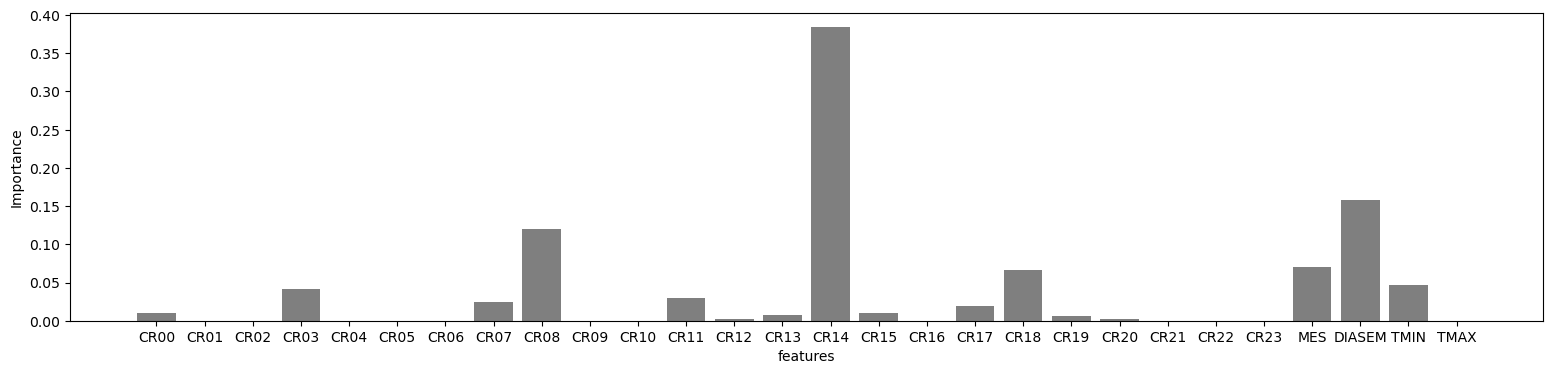

In [28]:
## Plot the variable importance of each feature
plt.figure(figsize=(19, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

Una vez realizado nuestro primer arbol podemos indicar los siguientes puntos:
- Este primer modelo es un modelo bastante bueno ya que tenemos un accuracy de 0.96 tanto en trainning como en test por lo que no hay overfitting
- Otro punto positivo es que el sensitivity es igual a 1 en ambos casos tambien
- Podriamos decir que la variable mas importante en este modelo es CR14 con una gran diferencia con respecto las demas y despues les siguen DIASEM, CR08 y MES

La capacidad de generación de un árbol de decisión se puede verificar mediante la evaluación del rendimiento del modelo en un conjunto de prueba que no se utilizó durante el entrenamiento. Hemos repetido este procedimiento varias veces para ver si podriamos mejorar el arbol y con el min_impurity_decrease igual a 0 hemos llegado al mas optimo pero podriamos llegar a mejorarlo si quitamos alguna varaible de entrada pero la mejora no seria muy grande ya que el arbol es capaz de distinguir que variables son las mas importantes para hacer las predicciones.

#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [8]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [9]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

In [10]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.6. Utiliza staking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

In [11]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


In [12]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [13]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [14]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_val)

Tamaño de df_val con los datos cargados: (357, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):
          FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0    2022-01-01  0.038935  0.037313  0.035291  0.033673  0.032924  0.033235   
1    2022-01-02  0.035271  0.033313  0.031889  0.031411  0.031302  0.031975   
2    2022-01-03  0.033756  0.032003  0.030669  0.030051  0.030199  0.031280   
3    2022-01-04  0.034484  0.032505  0.031375  0.030540  0.030431  0.031324   
4    2022-01-05  0.034669  0.032213  0.030933  0.030382  0.030527  0.031611   
..          ...       ...       ...       ...       ...       ...       ...   
352  2022-12-27  0.033279  0.031139  0.029907  0.029433  0.029757  0.030972   
353  2022-12-28  0.033250  0.031186  0.029934  0.029447  0.029821  0.030942   
354  2022-12-29  0.033718  0.031695  0.030290  0.029717  0.030014  0.031075   
355  2022-12-30  0.033673  0.031494  0.030124  0.029639  0.029629  0.030732   
356  20

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [15]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [16]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
